In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import pyreadr
import random

# to plot interaction networks of As and Ss; must be version >= 3.0 due to
# an update to MatPlotLib
from scipy.stats import nbinom, gamma, bernoulli
import statsmodels.api as sm
from statsmodels.formula.api import glm
import anndata as ad

from scipy.sparse import coo_matrix, csc_matrix


In this version, we will create a dataset with M/N=1000 patients, where there are two batches AND a physiological effect.
- Pull from two log normals to simulate batch, as we did before
- Also simulate a physiological difference. I guess we add/subtract values to certain genes? Should they be constant?

How to simulate a physiological effect
- maybe a multinomial to pick, say, 25% samples to increase, 25% to decrease, and 50% to leave alone
- Across the dataset, those genes counts are adjusted IN SOME WAY

We want to source this from the omegas rather than the counts.

In [ ]:
# Stick Breaking Algorithm
def generate_frequency_vector(number_probs):
    epsilon = 1e-8  # Small epsilon to ensure the number is strictly between l and r
    L = [[0, 1]]

    for i in range(number_probs-1):
        interval_index = random.randint(0, len(L) - 1)

        l, r = L[interval_index]
        number = random.uniform(l + epsilon, r - epsilon)

        new_intervals = [[l, number], [number, r]]

        

        L.pop(interval_index)

        L.insert(interval_index, new_intervals[1])
        L.insert(interval_index, new_intervals[0])

    freq = []
    for l in L:
        piece_of_stick = l[1] - l[0]
        # minimum in case the stick size < epsilon
        if (piece_of_stick < epsilon):
            piece_of_stick = epsilon

        freq.append(piece_of_stick)
    return freq


In [4]:
# set expirement type (as described in section 2.7 of the Methods of the PREFFECT paper)
# Experiment 1 : All genes have a batch effect applied
# Experiment 2 : Fraction of batch effect applied to genes (controlled by variable: prob_batch_effect)
# Experiment 3 : Fraction of batch effect applied to genes (controlled by variable: prob_batch_effect) + Samples split in two which use separate distributions to sample for omega (controlled by variable: omega_balance)
experiment = 2

In [ ]:
# Parameters go here
M=1000
N=900
batch_balance = 0.5
adjust_lib_size = False


libsize = 1000000 # L
mean_batch_shift = 1000 # B
theta = 1 
sigma = sigma_batch = 1 # sigma and sigma batch

omega_balance = 0



# Experiment #1
if (experiment == 1):
    prob_batch_effect = 1 # P (probability a gene gets a batch effect; I guess this means if 0.5, then 50% of batch 1 gets the batch effect for this gene)
    folder_save = "/path/to/output/dataset_omega_batch_1/L_Million_B1000/"


# Experiment #2
if (experiment == 2):
    prob_batch_effect = 0.5 # will also try 0.6, 0.7 ... 0.9
    folder_save = "/path/to/output/dataset_omega_batch_2/L_Million_B1000/"

# Experiment #3 (a "real" effect test)

if (experiment == 3):
    prob_batch_effect = 0.6 # will also try 0.6, 0.7 ... 0.9
    folder_save = "/path/to/output/dataset_omega_batch_3_60/L_Million_B1000/"

    omega_balance = 0.5

# Create directory
if not os.path.exists(folder_save):
    os.makedirs(folder_save)
    os.makedirs(folder_save + 'train/')
    os.makedirs(folder_save + 'validation/')

# in exp3, each gene gets it's own P based on a beta distribution

In [ ]:
# set omega frequency vector
omega_vector_1 = generate_frequency_vector(N)
omega_vector_2 = generate_frequency_vector(N)

print(np.sum(omega_vector_1), np.min(omega_vector_1), np.max(omega_vector_1))


# Set batch
samples_batch = np.random.binomial(n=1, p=batch_balance, size=M)
samples_batch_val = np.random.binomial(n=1, p=batch_balance, size=M)
print("# Samples in Batch 0/1: ", M - np.sum(samples_batch), np.sum(samples_batch))

# set distribution of two omega vector for experiment 3
samples_omega = np.random.binomial(n=1, p=omega_balance, size=M)
samples_omega_val = np.random.binomial(n=1, p=omega_balance, size=M)

1.000001381626447 1e-08 0.14018910156532735
# Samples in Batch 0/1:  535 465


In [ ]:
eps = epsilon = 1e-7
counts_append, counts_append_val, counts_append_2, counts_append_val_2 = [], [], [], []

# parameters to save
gene_omega_list, gene_mu_list, gene_theta_list, prob_effect_list = [], [], [], []
gene_omega_2_list, gene_mu_2_list = [], []

for gene_omega, gene_omega2 in zip(omega_vector_1, omega_vector_2):

    eps_omega = gene_omega + eps
    mu = eps_omega * libsize

    eps_omega_2 = gene_omega2 + eps
    mu_2 = eps_omega_2 * libsize

    # training
    #lognorm_mu = np.random.lognormal(mean=np.log(mu), sigma=theta, size=1)

    while True:
        norm_mu = np.random.normal(loc=mu, scale=sigma, size=1)
        norm_mu = norm_mu[0] # list -> value
        if (norm_mu > 0):
            break
    
    while True:
        norm_mu_2 = np.random.normal(loc=mu_2, scale=sigma, size=1)
        norm_mu_2 = norm_mu_2[0] # list -> value
        if (norm_mu_2 > 0):
            break
    
    # print(mu, norm_mu)

    var = norm_mu + (norm_mu**2 / theta)
    n = norm_mu**2 / (var - norm_mu)
    p = n / (n + norm_mu)

    var_2 = norm_mu_2 + (norm_mu_2**2 / theta)
    n_2 = norm_mu_2**2 / (var_2 - norm_mu_2)
    p_2 = n_2 / (n_2 + norm_mu_2)

    # NB counts across all patients generated
    counts_nobatch = nbinom.rvs(n, p, size=M)
    counts_nobatch_2 = nbinom.rvs(n_2, p_2, size=M)
    
    # now we want to identify which patients are of batch 1 and add the formulation

    if (experiment == 3):
        # old setup
        #prob_batch_effect_gene = np.random.beta(10, 3)
        # slight chance the value selected will be >1
        #if (prob_batch_effect_gene > 1):
        #    prob_batch_effect_gene = 1

        prob_batch_effect_gene = bernoulli.rvs(prob_batch_effect)
        p_effect = [prob_batch_effect_gene] * M

    else: 
        # experiment #1 and #2
        # switched to a Bernouli trial
        prob_batch_effect_gene = bernoulli.rvs(prob_batch_effect)
        p_effect = [prob_batch_effect_gene] * M
        

    norm_batch = np.random.normal(loc=mean_batch_shift, scale=sigma_batch, size=M)
    batch_effect = np.round(samples_batch * p_effect * norm_batch)

    # add batch effect and add to building matrix
    counts_batch = counts_nobatch + batch_effect
    counts_batch_2 = counts_nobatch_2 + batch_effect


    counts_append.append(counts_batch)
    counts_append_2.append(counts_batch_2)
    
    # save parameters
    gene_omega_list.append(eps_omega)
    gene_mu_list.append(norm_mu)
    gene_omega_2_list.append(eps_omega_2)
    gene_mu_2_list.append(norm_mu_2)
    gene_theta_list.append(theta)
    prob_effect_list.append(prob_batch_effect_gene)

    # validation

    # NB counts across all patients generated
    counts_nobatch_val = nbinom.rvs(n, p, size=M)
    counts_nobatch_val_2 = nbinom.rvs(n_2, p_2, size=M)
    
    # now we want to identify which patients are of batch 1 and add the formulation
    # first we randomly pick a probability range where the minimum is `prob_batch_effect`
    p_effect_val = np.random.binomial(n=1, p=prob_batch_effect_gene, size=M)
    
    #lognorm_batch_val = np.random.lognormal(mean=np.log(mean_batch_shift), sigma=theta_batch, size=M)

    norm_batch_val = np.random.normal(loc=mean_batch_shift, scale=sigma_batch, size=M)

    
    batch_effect_val = np.round(samples_batch_val * p_effect_val * norm_batch_val)

    # add batch effect and add to building matrix
    counts_batch_val = counts_nobatch_val + batch_effect_val
    counts_batch_val_2 = counts_nobatch_val_2 + batch_effect_val

    counts_append_val.append(counts_batch_val)
    counts_append_val_2.append(counts_batch_val_2)


In [8]:
# select which omega gets selected for which gene by samples_omega assignment
selected_data_train = np.where(samples_omega == 0, counts_append, counts_append_2)
selected_data_val = np.where(samples_omega_val == 0, counts_append_val, counts_append_val_2)

final_stick_counts = pd.DataFrame(np.transpose(selected_data_train))
final_stick_counts_val = pd.DataFrame(np.transpose(selected_data_val))

In [9]:
# We take the results from the count matrix and create an AnnData table for PREFFECT
# add batch information to "obs", create an adjacency matrix based on correlation

adata = ad.AnnData(X=final_stick_counts.values)

sample_names = ["sample_" + str(i) for i in range(M)]
adata.obs_names = sample_names
adata.obs['batch'] = pd.Series(samples_batch, index=adata.obs.index).astype('category')
adata.obs['omega_type'] = pd.Series(samples_omega, index=adata.obs.index).astype('category')

# save gene names and omegas
adata.var_names = ["gene_" + str(i) for i in range(N)]
adata.var['gene'] = adata.var_names
adata.var['omega_0'] = gene_omega_list
adata.var['mu_0'] = gene_mu_list
adata.var['omega_1'] = gene_omega_2_list
adata.var['mu_1'] = gene_mu_2_list
adata.var['theta'] = gene_theta_list
adata.var['batch_applied'] = pd.Series(prob_effect_list, index=adata.var.index).astype('category')

print(adata.var)

### CREATE EDGE MATRIX HERE

df_transposed = pd.DataFrame(adata.X.T, columns=adata.obs_names, index=adata.var_names)

correlation_matrix_samples = df_transposed.corr()
sample_sample_adj = (correlation_matrix_samples.abs() > 0.7).astype(int)
np.fill_diagonal(sample_sample_adj.values, 1)

# Count the number of 1s in the adjacency matrix
num_ones_samples = np.sum(sample_sample_adj.values)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata.obsm['sample_sample_adj'] = sample_sample_adj_coo
write_path = folder_save + "train/"
adata.write(write_path + 'dataset_omega_based_batch_effect.train.tau_1.h5ad')


#### VALIDATION ####
adata_val = ad.AnnData(X=final_stick_counts_val.values)

sample_names = ["sample_" + str(i) for i in range(M)]
adata_val.obs_names = sample_names
adata_val.obs['batch'] = pd.Series(samples_batch_val, index=adata_val.obs.index).astype('category')
adata_val.obs['omega_type'] = pd.Series(samples_omega_val, index=adata_val.obs.index).astype('category')

# save gene names and omegas
adata_val.var_names = ["gene_" + str(i) for i in range(N)]
adata_val.var['gene'] = adata_val.var_names
adata_val.var['omega_0'] = gene_omega_list
adata_val.var['mu_0'] = gene_mu_list
adata_val.var['omega_1'] = gene_omega_2_list
adata_val.var['mu_1'] = gene_mu_2_list
adata_val.var['theta'] = gene_theta_list
adata_val.var['batch_applied'] = pd.Series(prob_effect_list, index=adata_val.var.index).astype('category')


### CREATE EDGE MATRIX HERE

df_transposed = pd.DataFrame(adata_val.X.T, columns=adata_val.obs_names, index=adata_val.var_names)

correlation_matrix_samples = df_transposed.corr()
sample_sample_adj = (correlation_matrix_samples.abs() > 0.7).astype(int)
np.fill_diagonal(sample_sample_adj.values, 1)

# Count the number of 1s in the adjacency matrix
num_ones_samples = np.sum(sample_sample_adj.values)

# and the adjacency tables need to be 'coo'
sample_sample_adj_coo = csc_matrix(sample_sample_adj)
adata_val.obsm['sample_sample_adj'] = sample_sample_adj_coo
write_path = folder_save + "validation/"
adata_val.write(write_path + 'dataset_omega_based_batch_effect.validation.tau_1.h5ad')



              gene   omega_0         mu_0   omega_1           mu_1  theta  \
gene_0      gene_0  0.006435  6433.508940  0.000932     931.976211      1   
gene_1      gene_1  0.000493   492.309361  0.000687     688.631608      1   
gene_2      gene_2  0.001348  1347.435222  0.000549     549.650350      1   
gene_3      gene_3  0.000395   394.943477  0.000899     899.228144      1   
gene_4      gene_4  0.004728  4728.773619  0.003863    3862.541533      1   
...            ...       ...          ...       ...            ...    ...   
gene_895  gene_895  0.000064    64.515480  0.000205     205.367023      1   
gene_896  gene_896  0.000006     6.551318  0.108219  108219.638173      1   
gene_897  gene_897  0.000001     2.940325  0.009031    9031.093650      1   
gene_898  gene_898  0.002631  2630.768478  0.003438    3436.951762      1   
gene_899  gene_899  0.004273  4273.677674  0.024881   24880.026599      1   

         batch_applied  
gene_0               0  
gene_1               0  


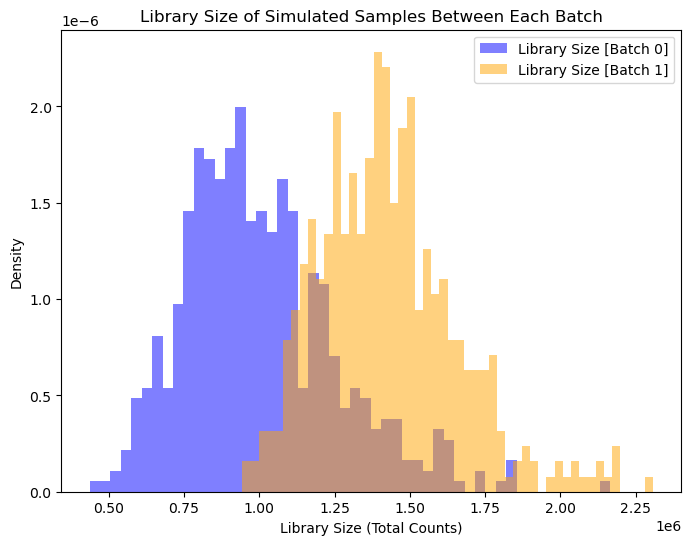

In [10]:

# normalize library size
library_sizes = adata.X.sum(axis=1)  # Sum across columns (genes)


if (adjust_lib_size):
    l_scale = libsize
    adata.X = np.round((adata.X / library_sizes[:, np.newaxis]) * l_scale)


batches = adata.obs['batch']
library_sizes_batch1 = library_sizes[batches == 0]
library_sizes_batch2 = library_sizes[batches == 1]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
plt.figure(figsize=(8, 6))
plt.hist(library_sizes_batch1, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [Batch 0]')
plt.hist(library_sizes_batch2, bins=50, density=True, alpha=0.5, color='orange', label='Library Size [Batch 1]')
plt.title('Library Size of Simulated Samples Between Each Batch')
plt.xlabel('Library Size (Total Counts)')
plt.ylabel('Density')

plt.legend()
plt.show()



In [11]:
# checking to see how many sample-sample "edges" were created in this run
print("# Sample Edges", np.sum(np.sum(sample_sample_adj)))

beta_sample = np.random.beta(10, 3)
print(beta_sample)

# Sample Edges 302650
0.8223574189518765


In [12]:
print(adata.X)
print(adata.obs)
print(adata.var)

[[1.5480e+03 2.2850e+03 1.0760e+03 ... 1.0010e+03 5.7160e+03 2.7080e+03]
 [6.5810e+03 7.0000e+00 3.4090e+03 ... 1.0090e+03 2.1730e+03 1.5410e+03]
 [9.6400e+02 8.0000e+02 3.2910e+03 ... 0.0000e+00 1.9470e+03 7.9600e+02]
 ...
 [1.3808e+04 3.5700e+02 5.1000e+02 ... 6.0000e+00 1.3930e+03 1.8810e+03]
 [4.9990e+03 2.1800e+02 4.2090e+03 ... 1.0000e+00 4.9580e+03 3.1930e+03]
 [1.9300e+03 7.9000e+01 1.9430e+03 ... 2.0000e+00 1.5410e+03 4.2440e+03]]
           batch omega_type
sample_0       1          0
sample_1       1          0
sample_2       0          0
sample_3       0          0
sample_4       1          0
...          ...        ...
sample_995     0          0
sample_996     1          0
sample_997     0          0
sample_998     0          0
sample_999     0          0

[1000 rows x 2 columns]
              gene   omega_0         mu_0   omega_1           mu_1  theta  \
gene_0      gene_0  0.006435  6433.508940  0.000932     931.976211      1   
gene_1      gene_1  0.000493   492.309361

In [ ]:
print(np.sum(adata.var['omega_0']))
print(np.sum(adata.var['omega_1']))

# should be ~1

1.0000913816264472
1.0000907330580608
